# Checkpoint 2

Implement here your algorithm to estimate the unknown parameters (fiber angle, anisotropy ratio and starting point position) from timings recorded in the 20 electrodes of the mapping catheter.

The algorithm should output the following information:
- your estimates of the fiber angle, anisotropy ratio and starting point position


In [1]:
# imports

import numpy as np
import matplotlib.pyplot as plt

In [2]:
!git clone https://github.com/Alepescinaa/ScientificTools
%cd ScientificTools/Project1/Cp2

Cloning into 'ScientificTools'...
remote: Enumerating objects: 354, done.
remote: Counting objects: 100% (198/198), done.
remote: Compressing objects: 100% (182/182), done.
remote: Total 354 (delta 56), reused 1 (delta 1), pack-reused 156
Receiving objects: 100% (354/354), 99.94 MiB | 9.61 MiB/s, done.
Resolving deltas: 100% (94/94), done.
/content/ScientificTools/Project1/Cp2


In [66]:
# loading of the dataset

CP2data = np.load("CP2data.npz")
CP2data = CP2data['arr_0']

# Display one recording

In [67]:
ind_disp = 4
x_meas = CP2data[ind_disp][0]
y_meas = CP2data[ind_disp][1]
t_meas = CP2data[ind_disp][2]

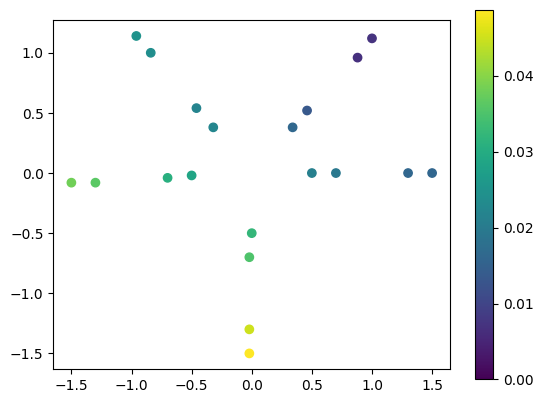

In [68]:
# Display a sample

plt.figure(1)
plt.scatter( x_meas,  y_meas, c=t_meas, vmin= 0, vmax=np.max(t_meas) )
plt.gca().set_aspect(1)
plt.colorbar()

In [69]:
# loading of the estimate

CP2estimate = np.load("CP2estimate.npz")
CP2estimate = CP2estimate['arr_0']

In [70]:
theta_fiber = CP2estimate[ind_disp][0]
a_ratio  = CP2estimate[ind_disp][1]
y0 = CP2estimate[ind_disp][2]

In [71]:
for i in range(5):
  print(CP2estimate[i])

[-0.25064471  8.42790456  0.94861542]
[ 0.03235073  6.62969993 -0.17485953]
[ 0.25291165  4.68768325 -1.22127016]
[-0.29207564  5.27909383  0.9323303 ]
[0.1226488  3.6316356  0.84714825]


# Function

Implemenatation of the algorithm presented in :

Sermesant, Maxime, et al. "An anisotropic multi-front fast marching method for real-time simulation of cardiac electrophysiology." Functional Imaging and Modeling of the Heart: 4th International Conference, FIHM 2007, Salt Lake City, UT, USA, June 7-9, 2007. Proceedings 4. Springer Berlin Heidelberg, 2007.

In [72]:
def anysotropic_FMM( x0 , y0 , X, Y, sigma_11,sigma_12, sigma_21, sigma_22 ):

    (j,i)= ( (np.abs(X-x0)).argmin(1)[0] , (np.abs(Y-y0)).argmin(0)[0]  )
    #print( i,j )
    #print(x0,y0)
    #print(X[i,j], Y[i,j])
    #print()

    T = (10^4)*(np.ones(np.shape(X)))
    T[i,j] = 0

    T_final = (10^4)*(np.ones(np.shape(X)))
    T_final[i,j] = 0

    TRIAL = [ (i,j) ]
    KNOWN = []
    KNOWN_C = []
    CHANGED = []

    KNOWN_MAT = (np.zeros(np.shape(X)))
    CHANGED_MAT = (np.zeros(np.shape(X)))

    def update_fun( T_xi,T_x,T_y, X_xi, X_x, X_y, Y_xi, Y_x, Y_y, flag_known, speed_val):

        if ( flag_known ):
            triangle_list = [ p*T_x+(1-p)*T_y + np.sqrt( sigma_11*( p*(X_xi-X_x) + (1-p)*(X_xi-X_y) )**2 + 2*sigma_12*( p*(X_xi-X_x) + (1-p)*(X_xi-X_y) )*( p*(Y_xi-Y_x) + (1-p)*(Y_xi-Y_y) ) + sigma_22*( p*(Y_xi-Y_x) + (1-p)*(Y_xi-Y_y) )**2 )/speed_val for p in np.arange(0,1.1,0.1)]
            T_xi = np.min( [ T_xi , np.min(triangle_list) ] )
        else:
            T_xi = np.min( [ T_xi , T_x + np.sqrt( sigma_11*( (X_xi-X_x) )**2 + 2*sigma_12*( (X_xi-X_x) )*( Y_xi-Y_x ) + sigma_22*( Y_xi-Y_x )**2 )/speed_val ] )

        return T_xi

    while (np.shape(TRIAL)[0]>0) | (np.shape(CHANGED)[0]>0):

        if (np.shape(CHANGED)[0]==0):
            ind_sel =  ( np.array([T_final[i,j] for (i,j) in TRIAL]) ).argmin()
            (i_sel,j_sel) = TRIAL[ind_sel]
            # add X to known
            KNOWN.append( TRIAL[ind_sel] )
            KNOWN_MAT[i_sel,j_sel] = 1
            # remove X from trial
            del TRIAL[ind_sel]
        else:
            ind_sel =  ( np.array([T_final[i,j] for (i,j) in CHANGED]) ).argmin()
            (i_sel,j_sel) = CHANGED[ind_sel]
            CHANGED_MAT[i_sel,j_sel] = 0
            # remove X from changed
            del CHANGED[ind_sel]

        T_X = T[i_sel,j_sel]

        # UPDATE 1

        if (i_sel!=0):

            #if ((i_sel-1,j_sel) in KNOWN ):
            if (KNOWN_MAT[i_sel-1,j_sel] == 1 ):

                #T[i_sel-1,j_sel] = 10^4

                if (j_sel!=150):

                    T[i_sel-1,j_sel] = update_fun(T_xi = T[i_sel-1,j_sel],T_x = T[i_sel,j_sel],T_y = T[i_sel-1,j_sel+1],
                                                X_xi = X[i_sel-1,j_sel], X_x= X[i_sel,j_sel], X_y= X[i_sel-1,j_sel+1],
                                                    Y_xi= Y[i_sel-1,j_sel], Y_x=Y[i_sel,j_sel], Y_y=Y[i_sel-1,j_sel+1],
                                                    flag_known =  (KNOWN_MAT[i_sel-1,j_sel+1] == 1 ),
                                                    speed_val = 100 )


                if (j_sel!=0):
                    #if ((i_sel-1,j_sel-1) in KNOWN ):

                    T[i_sel-1,j_sel] = update_fun(T_xi = T[i_sel-1,j_sel],T_x = T[i_sel,j_sel],T_y = T[i_sel-1,j_sel-1],
                                                X_xi = X[i_sel-1,j_sel], X_x= X[i_sel,j_sel], X_y= X[i_sel-1,j_sel-1],
                                                    Y_xi= Y[i_sel-1,j_sel], Y_x=Y[i_sel,j_sel], Y_y=Y[i_sel-1,j_sel-1],
                                                    flag_known =  (KNOWN_MAT[i_sel-1,j_sel-1] == 1 ),
                                                    speed_val = 100  )


                # if ((i_sel-1,j_sel) not in TRIAL ):
                #     TRIAL.append( (i_sel-1,j_sel) )
                if ( CHANGED_MAT[i_sel-1,j_sel] != 1 ):
                    if ( T[i_sel-1,j_sel] < T_final[i_sel-1,j_sel] ):
                        T_final[i_sel-1,j_sel] = T[i_sel-1,j_sel]
                        CHANGED.append( (i_sel-1,j_sel) )
                        CHANGED_MAT[i_sel-1,j_sel] = 1

        if (j_sel!=0):
            #if ((i_sel,j_sel-1) in KNOWN ):
            if (KNOWN_MAT[i_sel,j_sel-1] == 1 ):

                #T[i_sel,j_sel-1] = 10^4


                if (i_sel!=150):
                    #if ((i_sel+1,j_sel-1) in KNOWN ):

                    T[i_sel,j_sel-1] = update_fun(T_xi = T[i_sel,j_sel-1],T_x = T[i_sel,j_sel],T_y = T[i_sel+1,j_sel-1],
                                                X_xi = X[i_sel,j_sel-1], X_x= X[i_sel,j_sel], X_y= X[i_sel+1,j_sel-1],
                                                    Y_xi= Y[i_sel,j_sel-1], Y_x=Y[i_sel,j_sel], Y_y=Y[i_sel+1,j_sel-1],
                                                    flag_known =  (KNOWN_MAT[i_sel+1,j_sel-1] == 1 ) ,
                                                    speed_val = 100)


                if (i_sel!=0):
                    #if ((i_sel-1,j_sel-1) in KNOWN ):

                    T[i_sel,j_sel-1] = update_fun(T_xi = T[i_sel,j_sel-1],T_x = T[i_sel,j_sel],T_y = T[i_sel-1,j_sel-1],
                                                X_xi = X[i_sel,j_sel-1], X_x= X[i_sel,j_sel], X_y= X[i_sel-1,j_sel-1],
                                                    Y_xi= Y[i_sel,j_sel-1], Y_x=Y[i_sel,j_sel], Y_y=Y[i_sel-1,j_sel-1],
                                                    flag_known =  (KNOWN_MAT[i_sel-1,j_sel-1] == 1 ) ,
                                                    speed_val = 100 )

                #if ((i_sel,j_sel-1) not in TRIAL ):
                #    TRIAL.append( (i_sel,j_sel-1) )
                if ( CHANGED_MAT[i_sel,j_sel-1] != 1 ):
                    if ( T[i_sel,j_sel-1] < T_final[i_sel,j_sel-1] ):
                        T_final[i_sel,j_sel-1] = T[i_sel,j_sel-1]
                        CHANGED.append( (i_sel,j_sel-1) )
                        CHANGED_MAT[i_sel,j_sel-1] = 1
                    #T[i_sel,j_sel-1] = T[i_sel,j_sel] + np.sqrt( ( X[i_sel,j_sel-1]-X[i_sel,j_sel] )**2 + ( Y[i_sel,j_sel-1]-Y[i_sel,j_sel] )**2 )/100

        if (i_sel!=150):
            #if ((i_sel+1,j_sel) in KNOWN ):
            if (KNOWN_MAT[i_sel+1,j_sel] == 1 ):

                #T[i_sel+1,j_sel] = 10^4

                if (j_sel!=150):
                    #if ((i_sel+1,j_sel+1) in KNOWN ):

                    T[i_sel+1,j_sel] = update_fun(T_xi = T[i_sel+1,j_sel],T_x = T[i_sel,j_sel],T_y = T[i_sel+1,j_sel+1],
                                                X_xi = X[i_sel+1,j_sel], X_x= X[i_sel,j_sel], X_y= X[i_sel+1,j_sel+1],
                                                    Y_xi= Y[i_sel+1,j_sel], Y_x=Y[i_sel,j_sel], Y_y=Y[i_sel+1,j_sel+1],
                                                    flag_known =  (KNOWN_MAT[i_sel+1,j_sel+1] == 1 ) ,
                                                    speed_val = 100)

                if (j_sel!=0) :
                    #if ((i_sel+1,j_sel-1) in KNOWN ):

                    T[i_sel+1,j_sel] = update_fun(T_xi = T[i_sel+1,j_sel],T_x = T[i_sel,j_sel],T_y = T[i_sel+1,j_sel-1],
                                                X_xi = X[i_sel+1,j_sel], X_x= X[i_sel,j_sel], X_y= X[i_sel+1,j_sel-1],
                                                    Y_xi= Y[i_sel+1,j_sel], Y_x=Y[i_sel,j_sel], Y_y=Y[i_sel+1,j_sel-1],
                                                    flag_known =  (KNOWN_MAT[i_sel+1,j_sel-1] == 1 ) ,
                                                    speed_val = 100 )

                # if ((i_sel+1,j_sel) not in TRIAL ):
                #     TRIAL.append( (i_sel+1,j_sel) )
                if ( CHANGED_MAT[i_sel+1,j_sel] != 1 ):
                    if ( T[i_sel+1,j_sel] < T_final[i_sel+1,j_sel] ):
                        T_final[i_sel+1,j_sel] = T[i_sel+1,j_sel]
                        CHANGED.append( (i_sel+1,j_sel) )
                        CHANGED_MAT[i_sel+1,j_sel] = 1

        if (j_sel!=150):
            #if ((i_sel,j_sel+1) in KNOWN ):
            if (KNOWN_MAT[i_sel,j_sel+1] == 1 ):

                #T[i_sel,j_sel+1] = 10^4

                if (i_sel!=150):
                    #if ((i_sel+1,j_sel+1) in KNOWN ):
                    T[i_sel,j_sel+1] = update_fun(T_xi = T[i_sel,j_sel+1],T_x = T[i_sel,j_sel],T_y = T[i_sel+1,j_sel+1],
                                                X_xi = X[i_sel,j_sel+1], X_x= X[i_sel,j_sel], X_y= X[i_sel+1,j_sel+1],
                                                    Y_xi= Y[i_sel,j_sel+1], Y_x=Y[i_sel,j_sel], Y_y=Y[i_sel+1,j_sel+1],
                                                    flag_known =  (KNOWN_MAT[i_sel+1,j_sel+1] == 1 ) ,
                                                    speed_val = 100 )

                if (i_sel!=0):
                    #if ((i_sel-1,j_sel+1) in KNOWN ):

                    T[i_sel,j_sel+1] = update_fun(T_xi = T[i_sel,j_sel+1],T_x = T[i_sel,j_sel],T_y = T[i_sel-1,j_sel+1],
                                                X_xi = X[i_sel,j_sel+1], X_x= X[i_sel,j_sel], X_y= X[i_sel-1,j_sel+1],
                                                    Y_xi= Y[i_sel,j_sel+1], Y_x=Y[i_sel,j_sel], Y_y=Y[i_sel-1,j_sel+1],
                                                    flag_known =  (KNOWN_MAT[i_sel-1,j_sel+1] == 1 ) ,
                                                    speed_val = 100 )


                # if ((i_sel,j_sel+1) not in TRIAL ):
                #     TRIAL.append( (i_sel,j_sel+1) )
                if ( CHANGED_MAT[i_sel,j_sel+1] != 1 ):
                    if ( T[i_sel,j_sel+1] < T_final[i_sel,j_sel+1] ):
                        T_final[i_sel,j_sel+1] = T[i_sel,j_sel+1]
                        CHANGED.append( (i_sel,j_sel+1) )
                        CHANGED_MAT[i_sel,j_sel+1] = 1

        # UPDATE 2

        if (i_sel!=0):

            #if ((i_sel-1,j_sel) not in KNOWN ) :
            if (KNOWN_MAT[i_sel-1,j_sel] != 1 ):

                T[i_sel-1,j_sel] = 10^4

                if (j_sel!=150):
                    #if ((i_sel-1,j_sel+1) in KNOWN ):

                    T[i_sel-1,j_sel] = update_fun(T_xi = T[i_sel-1,j_sel],T_x = T[i_sel,j_sel],T_y = T[i_sel-1,j_sel+1],
                                                X_xi = X[i_sel-1,j_sel], X_x= X[i_sel,j_sel], X_y= X[i_sel-1,j_sel+1],
                                                    Y_xi= Y[i_sel-1,j_sel], Y_x=Y[i_sel,j_sel], Y_y=Y[i_sel-1,j_sel+1],
                                                    flag_known =  (KNOWN_MAT[i_sel-1,j_sel+1] == 1 ) ,
                                                    speed_val = 100 )

                if (j_sel!=0):
                    #if ((i_sel-1,j_sel-1) in KNOWN ):

                    T[i_sel-1,j_sel] = update_fun(T_xi = T[i_sel-1,j_sel],T_x = T[i_sel,j_sel],T_y = T[i_sel-1,j_sel-1],
                                                X_xi = X[i_sel-1,j_sel], X_x= X[i_sel,j_sel], X_y= X[i_sel-1,j_sel-1],
                                                    Y_xi= Y[i_sel-1,j_sel], Y_x=Y[i_sel,j_sel], Y_y=Y[i_sel-1,j_sel-1],
                                                    flag_known =  (KNOWN_MAT[i_sel-1,j_sel-1] == 1 ) ,
                                                    speed_val = 100 )

                if ((i_sel-1,j_sel) in TRIAL ):
                    if ( T[i_sel-1,j_sel] < T_final[i_sel-1,j_sel] ):
                        T_final[i_sel-1,j_sel] = T[i_sel-1,j_sel]
                else: # ((i_sel-1,j_sel) not in KNOWN ):
                    if ( T[i_sel-1,j_sel] < T_final[i_sel-1,j_sel] ):
                        T_final[i_sel-1,j_sel] = T[i_sel-1,j_sel]
                    #KNOWN_C.append( (i_sel-1,j_sel) )
                    TRIAL.append( (i_sel-1,j_sel) )

        if (j_sel!=0):
            #if ((i_sel,j_sel-1) not in KNOWN ) :
            if (KNOWN_MAT[i_sel,j_sel-1] != 1 ):

                T[i_sel,j_sel-1] = 10^4


                if (i_sel!=150):
                    #if ((i_sel+1,j_sel-1) in KNOWN ):

                    T[i_sel,j_sel-1] = update_fun(T_xi = T[i_sel,j_sel-1],T_x = T[i_sel,j_sel],T_y = T[i_sel+1,j_sel-1],
                                                X_xi = X[i_sel,j_sel-1], X_x= X[i_sel,j_sel], X_y= X[i_sel+1,j_sel-1],
                                                    Y_xi= Y[i_sel,j_sel-1], Y_x=Y[i_sel,j_sel], Y_y=Y[i_sel+1,j_sel-1],
                                                    flag_known =  (KNOWN_MAT[i_sel+1,j_sel-1] == 1 ) ,
                                                    speed_val = 100 )

                if (i_sel!=0):
                    #if ((i_sel-1,j_sel-1) in KNOWN ):

                    T[i_sel,j_sel-1] = update_fun(T_xi = T[i_sel,j_sel-1],T_x = T[i_sel,j_sel],T_y = T[i_sel-1,j_sel-1],
                                                X_xi = X[i_sel,j_sel-1], X_x= X[i_sel,j_sel], X_y= X[i_sel-1,j_sel-1],
                                                    Y_xi= Y[i_sel,j_sel-1], Y_x=Y[i_sel,j_sel], Y_y=Y[i_sel-1,j_sel-1],
                                                    flag_known =  (KNOWN_MAT[i_sel-1,j_sel-1] == 1 ),
                                                    speed_val = 100  )


                if ((i_sel,j_sel-1) in TRIAL ):
                    if ( T[i_sel,j_sel-1] < T_final[i_sel,j_sel-1] ):
                        T_final[i_sel,j_sel-1] = T[i_sel,j_sel-1]
                else : # ((i_sel,j_sel-1) not in KNOWN ):
                    if ( T[i_sel,j_sel-1] < T_final[i_sel,j_sel-1] ):
                        T_final[i_sel,j_sel-1] = T[i_sel,j_sel-1]
                    #KNOWN_C.append( (i_sel,j_sel-1) )
                    TRIAL.append( (i_sel,j_sel-1) )
                #T[i_sel,j_sel-1] = T[i_sel,j_sel] + np.sqrt( ( X[i_sel,j_sel-1]-X[i_sel,j_sel] )**2 + ( Y[i_sel,j_sel-1]-Y[i_sel,j_sel] )**2 )/100

        if (i_sel!=150):
            #if ((i_sel+1,j_sel) not in KNOWN ) :
            if (KNOWN_MAT[i_sel+1,j_sel] != 1 ):

                T[i_sel+1,j_sel] = 10^4

                if (j_sel!=150):
                    #if ((i_sel+1,j_sel+1) in KNOWN ):

                    T[i_sel+1,j_sel] = update_fun(T_xi = T[i_sel+1,j_sel],T_x = T[i_sel,j_sel],T_y = T[i_sel+1,j_sel+1],
                                                X_xi = X[i_sel+1,j_sel], X_x= X[i_sel,j_sel], X_y= X[i_sel+1,j_sel+1],
                                                    Y_xi= Y[i_sel+1,j_sel], Y_x=Y[i_sel,j_sel], Y_y=Y[i_sel+1,j_sel+1],
                                                    flag_known = (KNOWN_MAT[i_sel+1,j_sel+1] == 1 ) ,
                                                    speed_val = 100 )

                if (j_sel!=0) :
                    #if ((i_sel+1,j_sel-1) in KNOWN ):

                    T[i_sel+1,j_sel] = update_fun(T_xi = T[i_sel+1,j_sel],T_x = T[i_sel,j_sel],T_y = T[i_sel+1,j_sel-1],
                                                X_xi = X[i_sel+1,j_sel], X_x= X[i_sel,j_sel], X_y= X[i_sel+1,j_sel-1],
                                                    Y_xi= Y[i_sel+1,j_sel], Y_x=Y[i_sel,j_sel], Y_y=Y[i_sel+1,j_sel-1],
                                                    flag_known = (KNOWN_MAT[i_sel+1,j_sel-1] == 1 ),
                                                    speed_val = 100  )


                if ((i_sel+1,j_sel) in TRIAL ):
                    if ( T[i_sel+1,j_sel] < T_final[i_sel+1,j_sel] ):
                        T_final[i_sel+1,j_sel] = T[i_sel+1,j_sel]
                else: #if ((i_sel+1,j_sel) not in KNOWN ):
                    if ( T[i_sel+1,j_sel] < T_final[i_sel+1,j_sel] ):
                        T_final[i_sel+1,j_sel] = T[i_sel+1,j_sel]
                    #KNOWN_C.append( (i_sel+1,j_sel) )
                    TRIAL.append( (i_sel+1,j_sel) )

        if (j_sel!=150):
            #if ((i_sel,j_sel+1) not in KNOWN ) :
            if (KNOWN_MAT[i_sel,j_sel+1] != 1 ):

                T[i_sel,j_sel+1] = 10^4

                if (i_sel!=150):
                    #if ((i_sel+1,j_sel+1) in KNOWN ):

                    T[i_sel,j_sel+1] = update_fun(T_xi = T[i_sel,j_sel+1],T_x = T[i_sel,j_sel],T_y = T[i_sel+1,j_sel+1],
                                                X_xi = X[i_sel,j_sel+1], X_x= X[i_sel,j_sel], X_y= X[i_sel+1,j_sel+1],
                                                    Y_xi= Y[i_sel,j_sel+1], Y_x=Y[i_sel,j_sel], Y_y=Y[i_sel+1,j_sel+1],
                                                    flag_known = (KNOWN_MAT[i_sel+1,j_sel+1] == 1 ) ,
                                                    speed_val = 100 )

                if (i_sel!=0):
                    #if ((i_sel-1,j_sel+1) in KNOWN ):

                    T[i_sel,j_sel+1] = update_fun(T_xi = T[i_sel,j_sel+1],T_x = T[i_sel,j_sel],T_y = T[i_sel-1,j_sel+1],
                                                X_xi = X[i_sel,j_sel+1], X_x= X[i_sel,j_sel], X_y= X[i_sel-1,j_sel+1],
                                                    Y_xi= Y[i_sel,j_sel+1], Y_x=Y[i_sel,j_sel], Y_y=Y[i_sel-1,j_sel+1],
                                                    flag_known = (KNOWN_MAT[i_sel-1,j_sel+1] == 1 ) ,
                                                    speed_val = 100  )


                if ((i_sel,j_sel+1) in TRIAL ):
                    if ( T[i_sel,j_sel+1] < T_final[i_sel,j_sel+1] ):
                        T_final[i_sel,j_sel+1] = T[i_sel,j_sel+1]
                else: #if ((i_sel,j_sel+1) not in KNOWN ):
                    if ( T[i_sel,j_sel+1] < T_final[i_sel,j_sel+1] ):
                        T_final[i_sel,j_sel+1] = T[i_sel,j_sel+1]
                    #KNOWN_C.append( (i_sel,j_sel+1) )
                    TRIAL.append( (i_sel,j_sel+1) )

    return T_final

In [73]:
X, Y = np.meshgrid(np.linspace(-1.5,1.5,151), np.linspace(-1.5,1.5,151))

x0 = 1.5

theta0 = np.pi/2 - theta_fiber
a = np.array([np.cos(theta0), np.sin(theta0)]).T
b = np.array([np.cos(theta0-np.pi/2), np.sin(theta0-np.pi/2)]).T

D = ( (1/a_ratio)*np.tensordot(a, a,  axes=0) + np.tensordot(b, b,  axes=0) )
print(D)

D_inv = np.linalg.inv(D)
sigma_11 = D_inv[0][0]
sigma_12 = D_inv[0][1]
sigma_21 = D_inv[1][0]
sigma_22 = D_inv[1][1]

activation_time = anysotropic_FMM(x0 , y0 , X, Y, sigma_11,sigma_12, sigma_21, sigma_22) #funzione che mappa dallo spazio dei parametri a quello dei tempi

[[ 0.98915396 -0.08798785]
 [-0.08798785  0.28620407]]


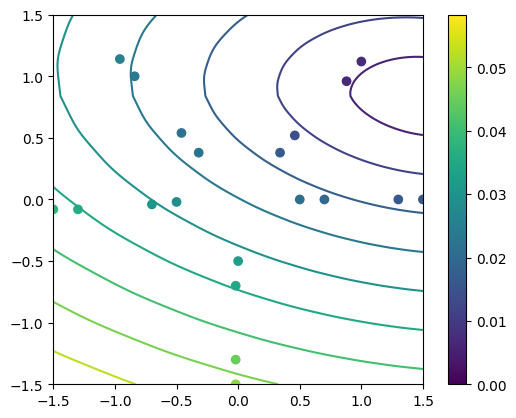

In [74]:
plt.contour(X, Y, activation_time , 10)
plt.scatter( x_meas,  y_meas, c=t_meas, vmin= 0, vmax=np.max(activation_time) )
plt.gca().set_aspect(1)
plt.colorbar()

# signature of the function

def checkpoint2_solution( x, y , t ):

return theta_fiber, a_ratio, y0



In [78]:
def CostFunctional(param, x_meas, y_meas, t_meas):

  theta_fiber=param[0]
  a_ratio=param[1]
  y0=param[2]
  theta0 = np.pi/2 - theta_fiber
  a = np.array([np.cos(theta0), np.sin(theta0)]).T
  b = np.array([np.cos(theta0-np.pi/2), np.sin(theta0-np.pi/2)]).T

  D = ( (1/a_ratio) * np.tensordot(a, a,  axes=0) + np.tensordot(b, b,  axes=0) )
  #print(D)

  D_inv = np.linalg.inv(D)
  sigma_11 = D_inv[0][0]
  sigma_12 = D_inv[0][1]
  sigma_21 = D_inv[1][0]
  sigma_22 = D_inv[1][1]

  activation_time = anysotropic_FMM(x0 , y0 , X, Y, sigma_11,sigma_12, sigma_21, sigma_22)
  sum = 0.0

  for k in range(20):
      i, j = np.where((X == x_meas[k]) & (Y == y_meas[k]))
      sum += (activation_time[i, j] - t_meas[k]) ** 2

  J = np.sqrt(sum/20)

  return J

In [99]:
import scipy
import time

def callback(xk):
    # This function will be called at each iteration
    print("Iteration:", callback.iteration)
    print("Parameters:", xk)

    callback.iteration += 1

callback.iteration = 1

def checkpoint2_solution(x, y , t):

    theta_fiber = 0
    a_ratio = 3
    y0 = 0
    param=(theta_fiber, a_ratio, y0)

    res = scipy.optimize.minimize(CostFunctional, param, args = (x,y,t), method='Nelder-Mead', tol = 1e-5, bounds = [(-np.pi / 20, np.pi / 20), (1, 9), (-1.5, 1.5)], callback = callback, options = {'maxiter': 200})
    print(res)

    return res.x

In [ ]:
theta_fiber, a_ratio, y0 = checkpoint2_solution(x_meas, y_meas , t_meas)

Iteration: 1
Parameters: [0.   3.15 0.  ]
Iteration: 2
Parameters: [ 4.16666667e-04  3.25000000e+00 -2.50000000e-04]
Iteration: 3
Parameters: [ 8.33333333e-05  3.50000000e+00 -5.00000000e-04]
Iteration: 4
Parameters: [ 1.66666667e-04  3.70000000e+00 -2.50000000e-04]
Iteration: 5
Parameters: [ 6.66666667e-04  4.15000000e+00 -1.00000000e-03]
Iteration: 6
Parameters: [ 6.66666667e-04  4.15000000e+00 -1.00000000e-03]
Iteration: 7
Parameters: [ 6.66666667e-04  4.15000000e+00 -1.00000000e-03]
Iteration: 8
Parameters: [ 6.66666667e-04  4.15000000e+00 -1.00000000e-03]
Iteration: 9
Parameters: [ 6.66666667e-04  4.15000000e+00 -1.00000000e-03]
Iteration: 10
Parameters: [ 5.39094650e-04  4.47067901e+00 -9.79938272e-04]
Iteration: 11
Parameters: [ 5.17318244e-04  4.41826132e+00 -1.04758230e-03]
Iteration: 12
Parameters: [ 1.33419067e-03  4.40560700e+00 -1.19418724e-03]
Iteration: 13
Parameters: [ 1.33419067e-03  4.40560700e+00 -1.19418724e-03]
Iteration: 14
Parameters: [ 1.33419067e-03  4.40560700

In [36]:
print(theta_fiber, a_ratio, y0)
print(CP2estimate[ind_disp][0], CP2estimate[ind_disp][1], CP2estimate[ind_disp][2])

0.15707963267948966 5.574382863601569 -0.03726130074866188
0.12264880421068648 3.6316355952332042 0.8471482485529079
